In [1]:
from scripts.xgb_results import xgb_results_regression
from pprint import pprint
from scripts.utils import *
from scripts.get_data import get_uci_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scripts.genetic import GeneticAlgorithmSampler
from scripts.fitness_funcs import *
from IPython.display import clear_output
from scripts.plots import *

In [2]:
x_train, x_test, y_train, y_test, description = get_uci_dataset(2) #Dataset 1 has 2 colums we need to predict...
pprint(description)

Number of features:  23
Number of training examples:  1711
Number of test examples:  428
{'categorical features': [],
 'dataset name': 'AIDS Clinical Trials Group Study 175',
 'number of features': 23,
 'number of samples': 2139,
 'variables information':        name     role        type         demographic  \
0    pidnum       ID     Integer                None   
1       cid   Target      Binary                None   
2      time  Feature     Integer                None   
3       trt  Feature     Integer                None   
4       age  Feature     Integer                 Age   
5      wtkg  Feature  Continuous                None   
6      hemo  Feature      Binary                None   
7      homo  Feature      Binary  Sexual Orientation   
8     drugs  Feature      Binary                None   
9    karnof  Feature     Integer                None   
10   oprior  Feature      Binary                None   
11      z30  Feature      Binary                None   
12   zprior  Fea

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1711, 23)
(1711,)
(428, 23)
(428,)


In [4]:
all_data_results = xgb_results_regression(x_train, x_test, y_train, y_test)
pprint(all_data_results)

{'Testing Metrics': {'MSE': 0.09032473560251866,
                     'Pearson': 0.7116221023900426,
                     'R^2 Score': 0.49901455274133955,
                     'Spearman': 0.607362871658546},
 'Training Metrics': {'MSE': 0.0004781508511815307,
                      'Pearson': 0.9988596827205314,
                      'R^2 Score': 0.9974183972225262,
                      'Spearman': 0.7454155672704781}}


In [5]:
guesses = get_baseline_guesses(np.concatenate((y_train, y_test)))
baseline_results = get_baseline_results(y_test, guesses)
pprint(baseline_results)

{'mean': {'MSE': 0.18035174548510868, 'R^2': -0.00031956111497111195},
 'median': {'MSE': 0.23598130841121495, 'R^2': -0.308868501529052}}


In [6]:
# sample rates are from 10 to 1000 in increments of 10
COMPARE = True
REDUNDANCY = 2 # TODO: was 5
sample_sizes = [100, 200, 300 ,400] # was [10, 50, 100, 150]

mse_dict_random, mse_dict_ga = {}, {}


for index, sample_size in enumerate(sample_sizes):
    clear_output()
    print('Sample Size:', sample_size, '\n')
    
    mse_list_random, mse_list_ga = [], []
    
    for i in range(REDUNDANCY):
        if (REDUNDANCY > 1):
            print('Iteration {}/{}'.format(i+1, REDUNDANCY))
        np.random.seed(i)
        
        x_train_sample, y_train_sample = sample_data(x_train, y_train, sample_size)
        
        Sampler = GeneticAlgorithmSampler(
            fitness_function=fitness_wasserstein_distance,
            sample_size=sample_size,
            x_train=x_train,
            y_train=y_train,
            population_size=2, # was 20
            max_generations=1, # was 10
            mutation_rate=0.6,
            mutation_cap=2,
            elite_size=1, # was 2
            verbose=False
        )


        Sampler = GeneticAlgorithmSampler(
            fitness_function=fitness_wasserstein_distance,
            sample_size=sample_size,
            x_train=x_train,
            y_train=y_train,
            population_size=2, # was 20
            max_generations=1, # was 10
            mutation_rate=0.6,
            mutation_cap=2,
            elite_size=1, # was 2
            verbose=False
        )
        
        x_train_new_sample, y_train_new_sample, history = Sampler.sample()
        
        results_random = xgb_results_regression(x_train_sample, x_test, y_train_sample, y_test)
        results_ga = xgb_results_regression(x_train_new_sample, x_test, y_train_new_sample, y_test)
        
        mse_random = results_random['Testing Metrics']['MSE']
        mse_ga = results_ga['Testing Metrics']['MSE']

        mse_list_random.append(mse_random)
        mse_list_ga.append(mse_ga)
        
        if COMPARE:
            print('\tRandom:', mse_random)
            print('\tGA:', mse_ga)
        print()

    mse_dict_random[sample_size] = mse_list_random
    mse_dict_ga[sample_size] = mse_list_ga


Sample Size: 400 

Iteration 1/2
	Generation 1
		Best fitness:  1.4221089610694653
	Random: 0.09977188776449589
	GA: 0.09616448260190665

Iteration 2/2
	Generation 1
		Best fitness:  1.3916887294651676
	Random: 0.11233235541246152
	GA: 0.10065066971786557



{'Random': [0.11735583605847048, 0.11553031971981996, 0.10682841293048301, 0.10605212158847871], 'GA': [0.12740989310179773, 0.11288889818787992, 0.10969814418259108, 0.0984075761598861]}
{'Random': [0.0036736606018864526, 0.011111850765471207, 0.003449660160923594, 0.006280233823982816], 'GA': [0.0016992728916544048, 0.01216134160932731, 0.010216268975872717, 0.002243093557979463]}


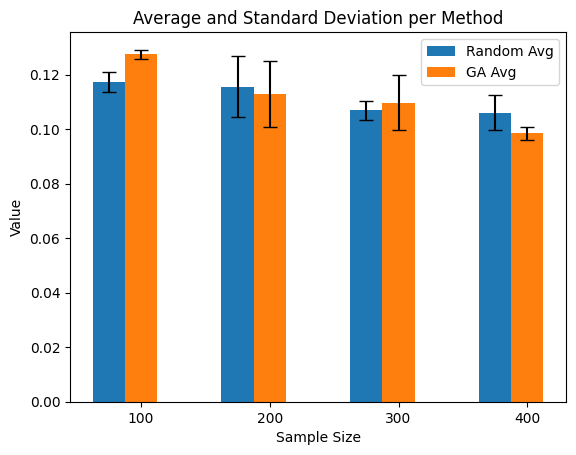

In [7]:
avg_dict ={}
std_dict = {}

avg_dict['Random'] = []
std_dict['Random'] = []
avg_dict['GA'] = []
std_dict['GA'] = []
for sample_size in sample_sizes:
    avg_dict['Random'].append(np.mean(mse_dict_random[sample_size]))
    std_dict['Random'].append(np.std(mse_dict_random[sample_size]))
    avg_dict['GA'].append(np.mean(mse_dict_ga[sample_size]))
    std_dict['GA'].append(np.std(mse_dict_ga[sample_size]))

# print(avg_dict)
# print(std_dict)

    
    

plot_comparison_bar(sample_sizes=sample_sizes,
                    avg_dict=avg_dict,
                    std_dict=std_dict,
                    methods=['Random', 'GA'])
                     

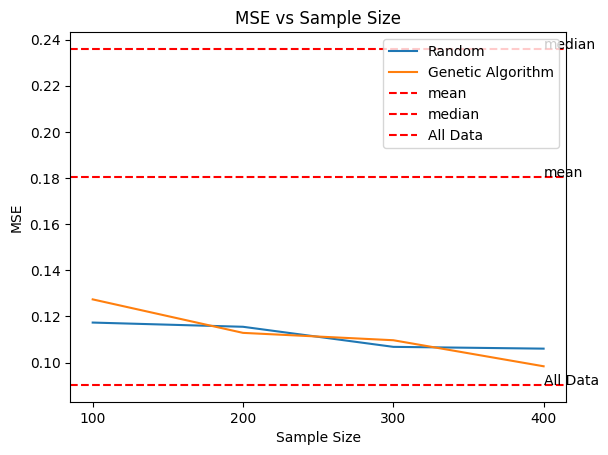

In [9]:
baseline_results_for_print = baseline_results.copy()
baseline_results_for_print['All Data']= all_data_results['Testing Metrics']


plot_comparison_line(metric_name = 'MSE',
                        dictionaries = [mse_dict_random, mse_dict_ga],
                        labels = ['Random', 'Genetic Algorithm'],
                        baseline_results = baseline_results_for_print)